In [45]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae, mape, rmse
nixtla_client = NixtlaClient(
    api_key = 'nixak-ZUBNbtRWb0JinHdA6NlRvMZkmH1YU7knytR4yi0JkGaBULEdSgElW5bKVIjf6RcXGdOSijcJSxAYvwzq'
)

nixtla_client.validate_api_key()


INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv('df.csv')
df["unique_id"] = 0
train_df = df[df['time'] <= '2022-12-31 23:55:00']
test_df = df[df['time'] >= '2023-01-01 00:00:00']


In [48]:
h = 24
context = 30000* 24
test       = df.tail(h)
input_seq  = df.iloc[-(context+h):-h]

In [49]:
fcst_df = nixtla_client.forecast(
    df           = input_seq.reset_index(drop=True),  # keep `time` as a COLUMN
    h            = h,
    level        = [90],
    finetune_steps = 10,
    finetune_loss  = "mae",
    model          = "timegpt-1-long-horizon",
    id_col       = "unique_id",
    time_col       = "time",
    target_col     = "DAP",          
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
/Users/natowei/ConcordNewEnergy/myenv/lib/python3.12/site-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['DAP 24H', 'DAP 7D', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew', 'is_holiday'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


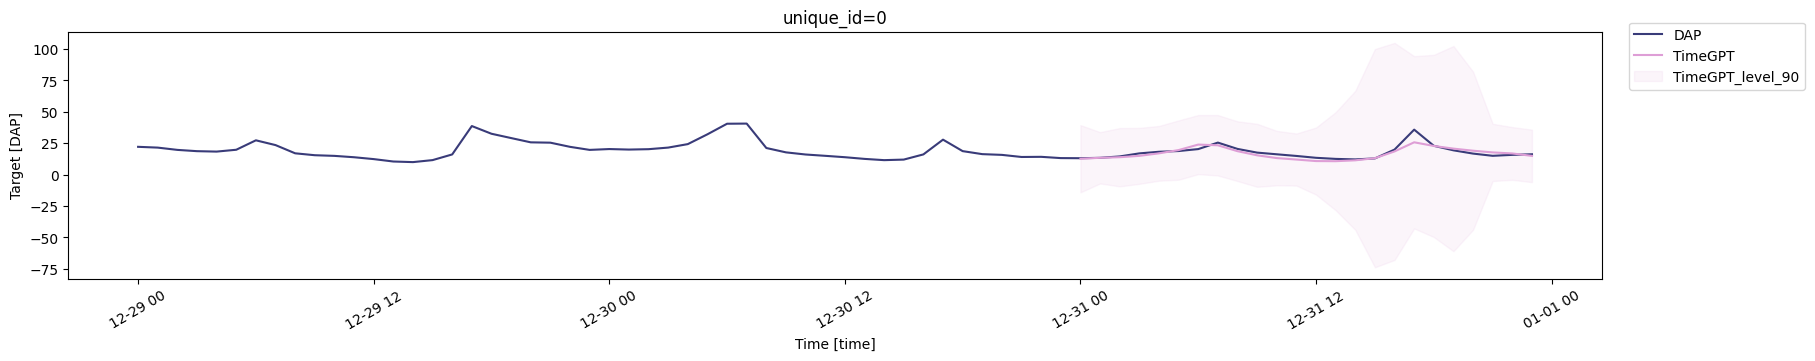

In [50]:
plot_window = df.tail(2*24 + h)      # 168 obs. of history + horizon
nixtla_client.plot(
    df          = plot_window.reset_index(drop=True),
    forecasts_df= fcst_df,
    models      = ["TimeGPT"],
    level       = [90],
    id_col       = "unique_id",
    time_col    = "time",
    target_col  = "DAP",
)

In [51]:
test.loc[:, "TimeGPT"] = fcst_df["TimeGPT"].values


evaluation = mae(test,
                 models     = ["TimeGPT"],
                 id_col     = "unique_id",
                 target_col = "DAP")
print(evaluation)


   unique_id   TimeGPT
0          0  1.931072


/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_5790/987237506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "TimeGPT"] = fcst_df["TimeGPT"].values


In [52]:

mape_val = mape(test, models=['TimeGPT'], id_col='unique_id', target_col='DAP')
rmse_val = rmse(test, models=['TimeGPT'], id_col='unique_id', target_col='DAP')
print(mape_val)

   unique_id   TimeGPT
0          0  0.102489


In [53]:
print(rmse_val)

   unique_id   TimeGPT
0          0  2.745733
